<a href="https://colab.research.google.com/github/kishiyamat/la-kentei-yaminabe/blob/main/notebooks/speech_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 母音とスペクトログラム、音脈分凝

### 母音の録音とスペクトログラムの描画

In [1]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

# 音声を保存する方法は以下のGist, Notebookを参照
# https://gist.github.com/tam17aki/8bfa2a42dab0061ee2641aed32dd1d30
# https://colab.research.google.com/github/espnet/notebook/blob/master/espnet2_asr_realtime_demo.ipynb

RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time));
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = e => resolve(e.srcElement.result);
  reader.readAsDataURL(blob);
});

var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true });

  // MediaRecorderをWebM形式で初期化
  const options = { mimeType: "audio/webm" };
  recorder = new MediaRecorder(stream, options);

  chunks = [];
  recorder.ondataavailable = e => chunks.push(e.data);
  recorder.start();
  await sleep(time);
  recorder.onstop = async () => {
    blob = new Blob(chunks);
    text = await b2text(blob);
    resolve(text);
  };
  recorder.stop();
});
"""

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

import tempfile
from base64 import b64decode
import librosa
import soundfile as sf

def record(sec, filename='audio.wav'):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec * 1000))
  b = b64decode(s.split(',')[1])
  with open(filename, 'wb+') as f:
    f.write(b)

In [2]:
! pip install praat-parselmouth
! pip install pydub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 24.0 MB/s eta 0:00:00


In [88]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='gray_r')
    # plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

In [15]:
# デフォルトで 'audio.wav' に保存される
# とりあえず3秒、「あいうえお」と言ってみる
# 実行とともに録音が開始される。
save_name = "tmp.wav"
record(3, save_name)

<IPython.core.display.Javascript object>

In [16]:
from IPython.display import display, Audio
rate = 16000
display(Audio(save_name, rate=rate))

In [87]:
import parselmouth

import soundfile as sf

# 読み込んでみる。初回実行時は時間がかかるかもしれない。
speech, rate = librosa.load(save_name, sr=rate)
# 一旦saveしないと上手く音声ファイルとして保存できない
sf.write(save_name, speech, rate)

# 配列をparselmouthのSoundオブジェクトに変換
snd = parselmouth.Sound(save_name)

<ipython-input-88-3e0b61fc9b66>:3: RuntimeWarning: divide by zero encountered in log10
  sg_db = 10 * np.log10(spectrogram.values)


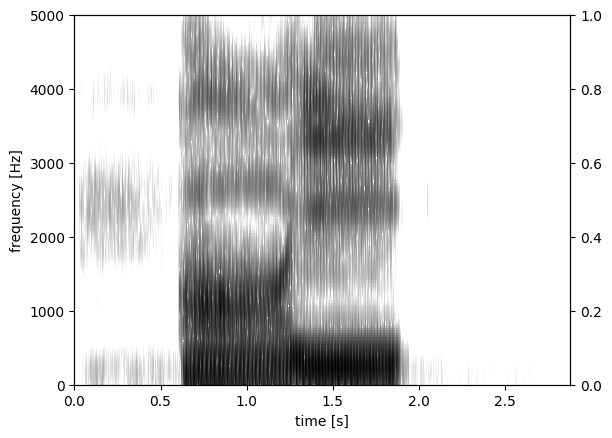

In [89]:
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
plt.xlim([snd.xmin, snd.xmax])
plt.show()

## 喉歌のサンプル

In [100]:
! pip install gdown soundfile

In [102]:
import gdown
import soundfile as sf

# 公開したGoogle DriveのファイルID
# https://drive.google.com/file/d/1xIsrsDP9-mrapy3FovuzNKoziyX8AUMj/view?usp=sharing
file_id = "1xIsrsDP9-mrapy3FovuzNKoziyX8AUMj"

# ダウンロード用のURLを作成
url = f'https://drive.google.com/uc?id={file_id}'

# ファイルをダウンロード
save_name = "khoomii-dl.wav"
gdown.download(url, save_name, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1xIsrsDP9-mrapy3FovuzNKoziyX8AUMj
To: /content/khoomii-dl.wav
100%|██████████| 159k/159k [00:00<00:00, 52.2MB/s]


'khoomii-dl.wav'

<ipython-input-88-3e0b61fc9b66>:3: RuntimeWarning: divide by zero encountered in log10
  sg_db = 10 * np.log10(spectrogram.values)


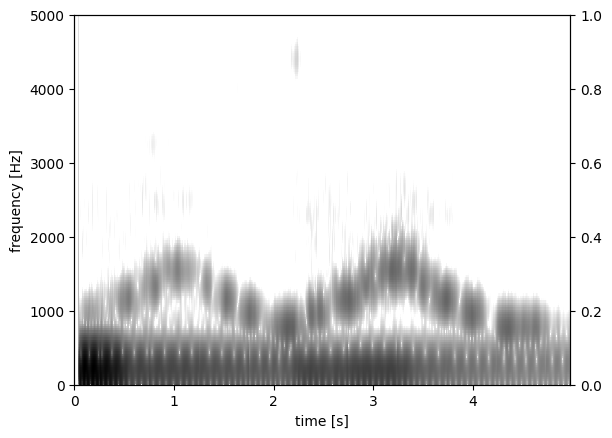

In [103]:
from IPython.display import display, Audio
rate = 16000
display(Audio(save_name, rate=rate))

# 配列をparselmouthのSoundオブジェクトに変換
snd = parselmouth.Sound(save_name)
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
plt.xlim([snd.xmin, snd.xmax])
plt.show()

## 音脈分凝

In [80]:
import librosa
import soundfile as sf
import numpy as np

# 音の持続時間
duration = 0.05  # 0.05秒

# サンプリングレート
sr = 16000

# 音を作る関数
def generate_tone(freq, duration, sr):
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    return 0.5 * np.sin(2 * np.pi * freq * t)

# 空白の音を作る関数
def generate_silence(duration, sr):
    return np.zeros(int(sr * duration))

# 各音を作成
A = generate_tone(1000, duration, sr)
B = generate_tone(1100, duration, sr)
C = generate_tone(2500, duration, sr)
D = generate_silence(duration, sr)

# 音のパターンを作成
pattern1 = np.concatenate([D, A, D, B, D, A, D, D]*4)
pattern2 = np.concatenate([D, A, D, C, D, A, D, D]*4)

# 音のパターンを保存
sf.write('pattern1.wav', pattern1, sr)
sf.write('pattern2.wav', pattern2, sr)


<ipython-input-88-3e0b61fc9b66>:3: RuntimeWarning: divide by zero encountered in log10
  sg_db = 10 * np.log10(spectrogram.values)


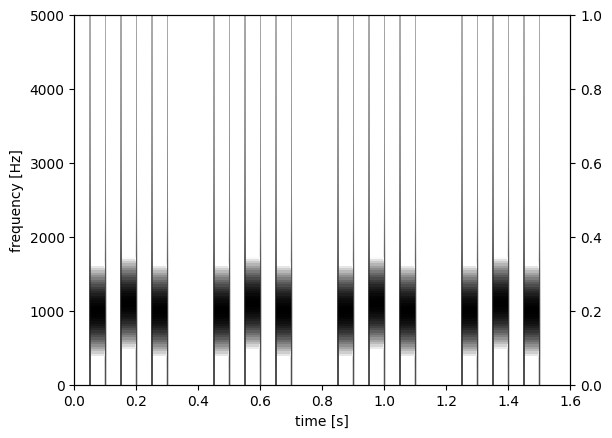

In [104]:
check = 'pattern1.wav'
snd = parselmouth.Sound(check)
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
plt.xlim([snd.xmin, snd.xmax])
plt.show()
display(Audio(check, rate=sr))

<ipython-input-88-3e0b61fc9b66>:3: RuntimeWarning: divide by zero encountered in log10
  sg_db = 10 * np.log10(spectrogram.values)


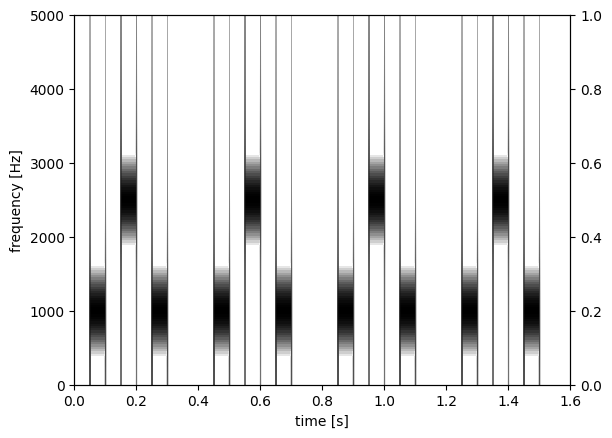

In [105]:
check = 'pattern2.wav'
snd = parselmouth.Sound(check)
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
plt.xlim([snd.xmin, snd.xmax])
plt.show()
display(Audio(check, rate=sr))